# Text Analysis
---

## Introduction

Text Analysis is used for summarizing or getting useful information out of a large amount of unstructured text stored in documents. This opens up the opportunity of using text data alongside more conventional data sources (e.g, surveys and administrative data). The goal of text analysis is to take a large corpus of complex and unstructured text data and extract important and meaningful messages in a comprehensible meaningful way. 


Text Analysis can help with the following tasks:

* **Informationan retrieval**: Help find relevant information in large databases such as a systematic literature review. 

* **Clustering and text categorization**: Techniques like topic modeling can summarize a large corpus of text by finding the most important phrases. 

* **Text Summarization**: Create category-sensitive text summaries of a large corpus of text. 

* **Machine Translation**: Translate from one language to another. 

In this tutorial, we are going to analyze job advertisements from 2010-2015 using topic modeling to examine the content of our data and document classification to tag the type of job in the advertisement. First we will go over how to transform our data into a matrix that can be read in by an algorithm. 
 


## Glossary of Terms

* **Corpus**: A corpus of documents is the set of all documents in the dataset.

* **Tokenize**: Tokenization is the process by which text is sepearated into meaningful terms or phrases. In english this is fairly triial as words as separated by whitespace. 

* **Stemming**: Stemming is a type of text normalization where words that have different forms but their essential meaning at the same are normalized to the original dictionary form of a word. For example "go," "went," and "goes" all stem from the lemma "go."

* **TFIDF**: TFIDF (Term frequency-inverse document frequency) is an example of feature enginnering where the most important words are extracted by taking account their frequency in documents and the entire corpus of documents as a whole.

* **Topic Modeling**: Topic modeling is an unsupervised learning method where groups of co-occuring words are clustered into topics. Typically, the words in a cluster should be related and make sense (e.g, boat, ship, captain). Individual documents will then fall into multiple topics. 

* **LDA**: LDA (latent Dirichlet allocation) is a type of probabilistic model commonly used for topic modelling. 

* **Stop Words**: Stop words are words that have little semantic meaning like prepositions, articles and common nouns. They can often be ignored. 

In [1]:
%pylab inline 
import nltk
import ujson
import re
import time
import progressbar

import pandas as pd
from __future__ import print_function
from six.moves import zip, range 

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_auc_score, auc
from sklearn import preprocessing
from collections import Counter, OrderedDict
from nltk.corpus import stopwords
from nltk import PorterStemmer

nltk.download('stopwords') #download the latest stopwords

Populating the interactive namespace from numpy and matplotlib


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ellio\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Load the Data

Our Dataset for this tutorial will be a subset jobs-ad data from 2010-2015 compiled by the Commonwealth of Virginia. The full data and how this subset was created can be found in the data folder in this tutorial.

In [2]:
df_jobs_data = pd.read_csv('./data/jobs_subset.csv')

# Explore the Data 

In [3]:
df_jobs_data.head()

,normalizedTitle_onetName,normalizedTitle_onetCode,jobDescription,title
0,Lawyers,23-1011.00,This position is in support of the United Stat...,"Paralegal (Buffalo, NY)"
1,Software Quality Assurance Engineers and Testers,15-1199.01,The successful candidate will maintain and dev...,System Integration / Test Engineer
2,Software Quality Assurance Engineers and Testers,15-1199.01,This position is a Senior System Integration &...,System Integration / Test Engineer Staff
3,Software Quality Assurance Engineers and Testers,15-1199.01,"In this position, candidates may participate i...",Mult Func Fin Analyst
4,Software Quality Assurance Engineers and Testers,15-1199.01,This is a business operations analyst position...,Mult Func Fin Analyst


Our table has 4 fields. `normalizedTitle_onetName`, `normalizedTitle_onetCode`, `jobDescription`, `title`

Onet is an online database that contains hundreds of occupational definitions. https://en.wikipedia.org/wiki/Occupational_Information_Network

The normalizedTitle_onetName and the normalizedTitle_onetCode are derived from the Onet Database. We wil use the names in the document tagging portion of the tutorial. The jobDescription is the actual jobDescription and the title is derived from the jobDescription. 

### How many unique job titles are in this dataset?

In [4]:
df_jobs_data.normalizedTitle_onetName.unique()

array(['Lawyers', 'Software Quality Assurance Engineers and Testers',
       'Graduate Teaching Assistants', 'Financial Examiners',
       'Credit Analysts'], dtype=object)

In [5]:
df_jobs_data.title.unique()

array(['Paralegal (Buffalo, NY)', 'System Integration / Test Engineer',
       'System Integration / Test Engineer Staff', ...,
       'JAVA ENGINEER(perm)', 'BSA Analyst', 'AML/KYC Analyst'],
      dtype=object)

In [6]:
df_jobs_data.title.unique().shape

(2496,)

There are 5 unique categories of jobs using the ONet classification. There are too many unique job titles in the title field to display. We can see the shape of the array of unique titles is 2496 titles. 

Each job description has a great deal of information contained in unstructered text. We can use text analysis to find overarching concepts that are in our corpus.  This will allow us to the discover the most important words and phrases in the job descriptions and give us a big-picture of the content in our collection. 



# Topic Modeling

 We are going to apply topic modeling, an unsuperivised learning method, to our corpus to find the high-level topics in our corpus as a first-go for exploring our data. As we apply topic modeling we will discuss ways of cleaning and preprocessing our data to get the best results.

Topic modeling is a broad subfield of machine learning and natural language processing. We are going to focus on one approach, Latent Dirichlet allocation (LDA). LDA is a fully Bayesian extension of probabilistic latent semantic  indexing, itself a probabilistic extension of latent semantic analysis.

In topic modeling we first assume the existence of topics in the corpus and that there is a small number of topics that can explain a corpus. Topics, in this case, are a ranked-list of words from our corpus, with the highest probability words at the top. A single document can be explained by multiple topics. For instance, an article on net neutrality has to do with both technology and politics. The set of topics used by a document is known as the document's allocation, hence, the name latent Dirchlet allocation, each document has an allocation of latent topics allocated by Dirchlet distribution. 

## Processing text data

The first important step in working with text data is cleaning and processing the data. This include but is not limited to *forming a corpus of text, tokenization, removing stop-words, finding words colocated together (N-grams), and stemming and lemmatization*. Each of these steps will be discussed below. The ultimate goal is to transform our text data into a form an algorithm can work with. A sequence of symbols cannot be fed directly into an algorithm. Algorithms expect numerical feature vectors with fixed size rather then a document with a variable document length. We will be transforming our text corpus into a *bag of n-grams* to be further analyzed. In this form our text data is represented as a matrix where each row refers to a specific job description (document) and each column is the occurence of a word (feature).


### Bag of n-gram representation example

Ultimately, we want to take our collection of documents, corpus, and convert it into a matrix. Fortunately sklearn has a pre-built object, `CountVectorizer`, that can tokenize, eliminate stopwords, identify n-grams and stem our corpus, outputing a matrix in one step. Before we apply the vectorizer on our corpus of data we are going to apply it to a toy example so we can understand the output and how a bag of words is represented. 

In [7]:
def create_bag_of_words(corpus,
                       NGRAM_RANGE=(0,1),
                       stop_words = None,
                        stem = False,
                       MIN_DF = 0.05,
                       MAX_DF = 0.95,
                       USE_IDF=False):
    """
    Turn a corpus of text into a bag-of-words.
    
    Parameters
    -----------
    corpus: ls
        test of documents in corpus    
    NGRAM_RANGE: tupule
        range of N-gram default (0,1)
    stop_words: ls
        list of commonly occuring words that have little semantic
        value
    stem: bool
        use a stemmer to stem words
    MIN_DF: float
       exclude words that have a frequency less than the threshold
    MAX_DF: float
        exclude words that have a frequency greater than the threshold
    
    
    Returns
    -------
    bag_of_words: scipy sparse matrix
        scipy sparse matrix of text
    features:
        ls of words
    """
    #parameters for vectorizer 
    ANALYZER = "word" #unit of features are single words rather then phrases of words 
    STRIP_ACCENTS = 'unicode'
     
    if stem:
        tokenize = lambda x: [stemmer.stem(i) for i in x.split()]
    else:
        tokenize = None
    vectorizer = CountVectorizer(analyzer=ANALYZER,
                                tokenizer=tokenize, 
                                ngram_range=NGRAM_RANGE,
                                stop_words = stop_words,
                                strip_accents=STRIP_ACCENTS,
                                min_df = MIN_DF,
                                max_df = MAX_DF)
    
    bag_of_words = vectorizer.fit_transform( corpus ) #transform our corpus is a bag of words 
    features = vectorizer.get_feature_names()

    if USE_IDF:
        NORM = None #turn on normalization flag
        SMOOTH_IDF = True #prvents division by zero errors
        SUBLINEAR_IDF = True #replace TF with 1 + log(TF)
        transformer = TfidfTransformer(norm = NORM,smooth_idf = SMOOTH_IDF,sublinear_tf = True)
        #get the bag-of-words from the vectorizer and
        #then use TFIDF to limit the tokens found throughout the text 
        tfidf = transformer.fit_transform(bag_of_words)
        
        return tfidf, features
    else:
        return bag_of_words, features

In [8]:
toy_corpus = ['this is document one', 'this is document two', 'text analysis on documents is fun'] 

In [9]:
toy_bag_of_words, toy_features = create_bag_of_words(toy_corpus)

The counter_vectorizer outputs a matrix. In this case a sparse matrix, a matrix that has a lot more 0s then 1s. To save space scipy has special methods for storing sparse matrices in a space-efficient way rather than saving many many 0s. 

In [10]:
toy_corpus

['this is document one',
 'this is document two',
 'text analysis on documents is fun']

In [11]:
np_bag_of_words = toy_bag_of_words.toarray()
np_bag_of_words

array([[0, 1, 0, 0, 0, 1, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 1],
       [1, 0, 1, 1, 1, 0, 1, 0, 0]], dtype=int64)

In [12]:
toy_features

['analysis',
 'document',
 'documents',
 'fun',
 'on',
 'one',
 'text',
 'this',
 'two']

Our data has been transformed into a 3x9 matrix where each row corresponds to a document and the columns correspond to the features. A 1 indicates the existence of the feature or word in the document, 0 indicates the word is not present.Our toy corpus is now ready to be analyzed. We illustrated bag of n-gram with a toy example because the matrix for a much larger corpus would be much larger and harder to interpet on our corpus of data. 

##### word counts

As a initial look into the data we can examine what the top few words are in our corpus. We can sum the columns of the bag_of_words and then convert to a numpy array. From here we can zip the features and word_count into a dictionary
and display the results.

In [22]:
def get_word_counts(bag_of_words, feature_names):
    """
    Get the ordered word counts from a bag_of_words
    
    Parameters
    ----------
    bag_of_words: obj
        scipy sparse matrix from CounterVectorizer
    feature_names: ls
        list of words
        
    Returns
    -------
    word_counts: dict
        Dictionary of word counts
    """
    np_bag_of_words = bag_of_words.toarray()
    word_count = np.sum(np_bag_of_words,axis=0)
    np_word_count = np.asarray(word_count).ravel()
    dict_word_counts = dict( zip(feature_names, np_word_count) )
    
    orddict_word_counts = OrderedDict( 
                                    sorted(dict_word_counts.items(), key=lambda x: x[1], reverse=True), )
    
    return orddict_word_counts

In [23]:
get_word_counts(toy_bag_of_words, toy_features)

OrderedDict([('document', 2),
             ('this', 2),
             ('analysis', 1),
             ('documents', 1),
             ('fun', 1),
             ('on', 1),
             ('one', 1),
             ('text', 1),
             ('two', 1)])

### Text Corpora

First we need to form our corpus, a set of multiple similiar documents. In our case, our corpus is the set of all job descriptions. We can pull out the job descriptions from the data frame by pulling out the underlying numpy array using the `.values` attribute. 

In [24]:
corpus = df_jobs_data['jobDescription'].values #pull all the jobDescriptions and put them in a numpy array 
corpus

array(["This position is in support of the United States Attorney's Office in Buffalo, NY located at 138 Delaware Avenue. The estimated length of this assignment is through May 31, 2016 with the possibility of extensions. Overtime and travel may be authorized as needed. The Employee will perform the following tasks, but not limited to: *Serves as a primary resource for the office on all aspects of docketing. *Recommends revisions in office procedures to improve the docketing function by expediting case processing, changing codes for data elements, etc. *Reviews reports to identify recurring errors and trains new employees in the operation and use of the case tracking system. Advises other personnel on appropriate codes for unprecedented cases. Explains the operation of the system and importance of timely information to new attorneys and support staff. *Responsibility for developing/maintaining automated records for the criminal and civil case workload from initial referral to final dis

In [34]:
def create_topics(tfidf, features, N_TOPICS=3, N_TOP_WORDS=5,):
    """
    Given a matrix of features of text data generate topics
    
    Parameters
    -----------
    tfidf: scipy sparse matrix
        sparse matrix of text features
    N_TOPICS: int
        number of topics (default 10)
    N_TOP_WORDS: int
        number of top words to display in each topic (default 10)
        
    Returns
    -------
    ls_keywords: ls
        list of keywords for each topics
    doctopic: array
        numpy array with percentages of topic that fit each category
    N_TOPICS: int
        number of assumed topics
    N_TOP_WORDS: int
        Number of top words in a given topic. 
    """
    
#    with progressbar.ProgressBar(max_value=progressbar.UnknownLength) as bar:
#        i=0
#        lda = LatentDirichletAllocation( n_topics= N_TOPICS,
#                                       learning_method='online') #create an object that will create 5 topics
#        bar.update(i)
#        i+=1
#        doctopic = lda.fit_transform( tfidf )
#        bar.update(i)
#        i+=1
#        
#        ls_keywords = []
#        for i,topic in enumerate(lda.components_):
#            word_idx = np.argsort(topic)[::-1][:N_TOP_WORDS]
#            keywords = ', '.join( features[i] for i in word_idx)
#            ls_keywords.append(keywords)
#            print(i, keywords)
#            bar.update(i)
#            i+=1
# Version of progressbar is old.  Update function definition with latest progressbar command

    bar = progressbar.ProgressBar()
    bar.start()
    i=0
    lda = LatentDirichletAllocation( n_components= N_TOPICS,
                                   learning_method='online') #create an object that will create 5 topics
    bar.update(i)
    i+=1
    doctopic = lda.fit_transform( tfidf )
    bar.update(i)
    i+=1
    
    ls_keywords = []
    for i,topic in enumerate(lda.components_):
        word_idx = np.argsort(topic)[::-1][:N_TOP_WORDS]
        keywords = ', '.join( features[i] for i in word_idx)
        ls_keywords.append(keywords)
        print(i, keywords)
        bar.update(i)
        i+=1
    
    bar.finish()
            
    return ls_keywords, doctopic

In [32]:
corpus_bag_of_words, corpus_features = create_bag_of_words(corpus)

Let's examine our features. 

In [28]:
corpus_features

['00',
 '000',
 '10',
 '100',
 '11',
 '12',
 '15',
 '20',
 '2015',
 '25',
 '30',
 '40',
 '50',
 '500',
 '80',
 '800',
 'aa',
 'abilities',
 'ability',
 'able',
 'about',
 'above',
 'academic',
 'access',
 'accordance',
 'according',
 'accounting',
 'accounts',
 'accredited',
 'accuracy',
 'accurate',
 'achieve',
 'across',
 'act',
 'action',
 'active',
 'activities',
 'addition',
 'additional',
 'administration',
 'administrative',
 'admired',
 'advance',
 'advanced',
 'affirmative',
 'again',
 'against',
 'age',
 'agencies',
 'agency',
 'agile',
 'agreeing',
 'al',
 'all',
 'along',
 'also',
 'an',
 'analysis',
 'analyst',
 'analytical',
 'analyze',
 'and',
 'anos',
 'any',
 'applicable',
 'applicants',
 'application',
 'applications',
 'apply',
 'applying',
 'appropriate',
 'architecture',
 'are',
 'area',
 'areas',
 'around',
 'as',
 'aspects',
 'assessment',
 'assigned',
 'assist',
 'assistance',
 'assistant',
 'assisting',
 'assists',
 'associate',
 'associated',
 'assurance',
 'a

The first aspect of the feature list that should stand out for us is that the first few entries are numbers that have no real semantic meaning. There are also other useless words such as prepositions and articles that also have no semantic meaning. The words *ability* or *abilities* or *accuracy* and *accurate* are also quite similiar and mean the same thing. We should try cleaning our corpus of data of these types of words as they just add noise to our analysis. Nevertheless let's try creating topics and seeing the quality of the results. 

In [29]:
get_word_counts(corpus_bag_of_words, corpus_features)

OrderedDict([('and', 72036),
             ('to', 36758),
             ('the', 34940),
             ('of', 31793),
             ('in', 23879),
             ('with', 16877),
             ('for', 15605),
             ('or', 13556),
             ('experience', 11108),
             ('is', 10153),
             ('de', 8563),
             ('as', 8252),
             ('be', 7101),
             ('on', 7003),
             ('work', 6583),
             ('our', 6556),
             ('will', 5949),
             ('are', 5769),
             ('an', 5686),
             ('job', 5631),
             ('software', 5360),
             ('skills', 5337),
             ('we', 5198),
             ('development', 5079),
             ('you', 4884),
             ('test', 4744),
             ('this', 4584),
             ('team', 4450),
             ('all', 4442),
             ('that', 4267),
             ('ability', 4248),
             ('other', 4207),
             ('required', 4147),
             ('business', 4010),
   

Our top words are articles, prepositions and conjunctions that do not tell us anything about our courpus. Let's march on create topics anyway.

In [35]:
ls_corpus_keywords, corpus_doctopic = create_topics(corpus_bag_of_words, corpus_features)

0 and, to, the, of, in
1 de, en, la, con, el
2 and, to, the, of, in


Looking at these topics we have no real knowledge of what is in our corpus, with the exception that there are job ads written in Spanish. The problem is the the top words in the topics are conjunctions and prepositions that have no semantic information. We have to try and clean and process our data to get more meaningful infomation. 

### Text Cleaning and Normalization

To clean and normalize text we will remove all special characters, numbers, and punctuation. Then we will make all the text lowercase to normalize the text;  this is so words like "the" and "The" will be counted as the same in our analysis. To remove the special characters, numbers and punctuation we will use regular expressions. 

#### Regular Expressions

>"Some people, when confronted with a problem, think 
>'I know, I'll use regular expressions.'   Now they have two problems."
> -- Jaime Zawinski

Regular Expressions or regexes match a certain amount text in a document based on a set of rules and syntax. The name "regular expressions" actually comes from the mathematical theory it is based on. These rules are useful for pulling out useful information in a large amount of text (e.g., email addresses, html-tags, credit card numbers). Regexes often match text much more quickly then plain text sorting and can often reduce their development time. Some regular expressions can become quite complicated and it may then become a good idea to write code using Python. Any developer should keep in mind there is a trade-off between optimization and understandibility. In Python, a general philosophy is code is meant to be as understandable by *people* as much as possible. You should therefore always tend toward the understandabilty side of things rather than overly optimizing your code. Your future-self, code-reviewers, people who inherit your code, and anyone else who has to make sense of your code in the future will appreciate it. 

For our purposes we are going to use a regular expression to match all characters that are not letters -- punctutation, quotes, special characters and numbers --replace them with spaces and then take all the remaining characters and make them lowercase. 

A full tutorial on regular expressions would be outside the scope of this tutorial. There are many good tutorials that can be found on-line. There is also a great interactive tool for developing and checking regular expressions regex101.com. 

We will be using the `re` library in python for regular expression matching.

In [36]:
#get rid of the punctuations and set all characters to lowercase
RE_PREPROCESS = r'\W+|\d+' #the regular expressions that matches all non-characters

#get rid of punctuation and make everything lowercase
#the code belows works by looping through the array of text
#for a given piece of text we invoke the `re.sub` command where we pass in the regular expression, a space ' ' to
#subsitute all the matching characters with
#we then invoke the `lower()` method on the output of the re.sub command
#to make all the remaining characters
#the cleaned document is then stored in a list
#once this list has been filed it is then stored in a numpy array

processed_corpus = np.array( [ re.sub(RE_PREPROCESS, ' ', comment).lower() for comment in corpus] )

#### first decription before cleaning

In [37]:
corpus[0]

"This position is in support of the United States Attorney's Office in Buffalo, NY located at 138 Delaware Avenue. The estimated length of this assignment is through May 31, 2016 with the possibility of extensions. Overtime and travel may be authorized as needed. The Employee will perform the following tasks, but not limited to: *Serves as a primary resource for the office on all aspects of docketing. *Recommends revisions in office procedures to improve the docketing function by expediting case processing, changing codes for data elements, etc. *Reviews reports to identify recurring errors and trains new employees in the operation and use of the case tracking system. Advises other personnel on appropriate codes for unprecedented cases. Explains the operation of the system and importance of timely information to new attorneys and support staff. *Responsibility for developing/maintaining automated records for the criminal and civil case workload from initial referral to final dispositio

#### first description after cleaning

In [38]:
processed_corpus[0]

'this position is in support of the united states attorney s office in buffalo ny located at   delaware avenue the estimated length of this assignment is through may     with the possibility of extensions overtime and travel may be authorized as needed the employee will perform the following tasks but not limited to serves as a primary resource for the office on all aspects of docketing recommends revisions in office procedures to improve the docketing function by expediting case processing changing codes for data elements etc reviews reports to identify recurring errors and trains new employees in the operation and use of the case tracking system advises other personnel on appropriate codes for unprecedented cases explains the operation of the system and importance of timely information to new attorneys and support staff responsibility for developing maintaining automated records for the criminal and civil case workload from initial referral to final disposition regularly inputs new i

All lowercase, all numbers and special chracters have been removed. Out text is now normalized.

### Tokenization

Now that we have cleaned our text we can tokenize it by deciding which terms and phrases are the most meaningful. In this case we want to split our text into individual words. Our words are separted by spaces so we can use the `.split()` command to turn are document into a list of words using a space as the character to split on as an example. Normally the `CountVectorizer` handles this for us.  

In [39]:
tokens = processed_corpus[0].split()

In [40]:
tokens

['this',
 'position',
 'is',
 'in',
 'support',
 'of',
 'the',
 'united',
 'states',
 'attorney',
 's',
 'office',
 'in',
 'buffalo',
 'ny',
 'located',
 'at',
 'delaware',
 'avenue',
 'the',
 'estimated',
 'length',
 'of',
 'this',
 'assignment',
 'is',
 'through',
 'may',
 'with',
 'the',
 'possibility',
 'of',
 'extensions',
 'overtime',
 'and',
 'travel',
 'may',
 'be',
 'authorized',
 'as',
 'needed',
 'the',
 'employee',
 'will',
 'perform',
 'the',
 'following',
 'tasks',
 'but',
 'not',
 'limited',
 'to',
 'serves',
 'as',
 'a',
 'primary',
 'resource',
 'for',
 'the',
 'office',
 'on',
 'all',
 'aspects',
 'of',
 'docketing',
 'recommends',
 'revisions',
 'in',
 'office',
 'procedures',
 'to',
 'improve',
 'the',
 'docketing',
 'function',
 'by',
 'expediting',
 'case',
 'processing',
 'changing',
 'codes',
 'for',
 'data',
 'elements',
 'etc',
 'reviews',
 'reports',
 'to',
 'identify',
 'recurring',
 'errors',
 'and',
 'trains',
 'new',
 'employees',
 'in',
 'the',
 'operati

### Stopwords

Stopwords are words that have very little semantic meaning and are found throughout a text. Having the word *the* or *of* will tell us nothing about our corpus, nor will they be meaningful features.  Examples of stopwords are prepositions, articles and common nouns. To process the corpus even further we can eliminate these stopwords by checking if the are in a list of commonly occuring stopwords.


In [41]:
eng_stopwords =  stopwords.words('english')

In [42]:
#sample of stopwords
eng_stopwords[::10]

['i',
 "you've",
 'himself',
 'they',
 'that',
 'been',
 'a',
 'while',
 'through',
 'in',
 'here',
 'few',
 'own',
 'just',
 're',
 'doesn',
 'ma',
 "shouldn't"]

In [43]:
processed_bag_of_words, processed_features = create_bag_of_words(processed_corpus,stop_words=eng_stopwords)
dict_processed_word_counts = get_word_counts(processed_bag_of_words, processed_features)
dict_processed_word_counts

OrderedDict([('experience', 11108),
             ('de', 8575),
             ('work', 6583),
             ('job', 5631),
             ('software', 5360),
             ('skills', 5337),
             ('development', 5079),
             ('test', 4744),
             ('team', 4450),
             ('ability', 4248),
             ('required', 4147),
             ('business', 4010),
             ('quality', 3664),
             ('requirements', 3653),
             ('position', 3494),
             ('testing', 3413),
             ('knowledge', 3366),
             ('years', 3336),
             ('management', 3320),
             ('must', 3261),
             ('systems', 3103),
             ('engineering', 3047),
             ('services', 3043),
             ('information', 2989),
             ('support', 2955),
             ('legal', 2816),
             ('en', 2791),
             ('status', 2757),
             ('opportunity', 2734),
             ('including', 2627),
             ('working', 2559),
   

Much better! Now let's see how this affects the topics that are produce. Though the top 20 words are likely to be in all the job ads. Let's add them to the stopwords to remove them as well. 

In [44]:
top_20_words = list(dict_processed_word_counts.keys())[:20]
domain_specific_stopwords = eng_stopwords + top_20_words
processed_bag_of_words, processed_features = create_bag_of_words(processed_corpus,
                                                                 stop_words=domain_specific_stopwords)


In [45]:
dict_processed_word_counts = get_word_counts(processed_bag_of_words, processed_features)
dict_processed_word_counts

OrderedDict([('systems', 3103),
             ('engineering', 3047),
             ('services', 3043),
             ('information', 2989),
             ('support', 2955),
             ('legal', 2816),
             ('en', 2791),
             ('status', 2757),
             ('opportunity', 2734),
             ('including', 2627),
             ('working', 2559),
             ('design', 2531),
             ('company', 2528),
             ('technical', 2487),
             ('data', 2359),
             ('provide', 2307),
             ('time', 2297),
             ('degree', 2276),
             ('related', 2264),
             ('new', 2242),
             ('strong', 2206),
             ('environment', 2105),
             ('qualifications', 2103),
             ('system', 2072),
             ('compliance', 2019),
             ('equal', 1993),
             ('preferred', 1925),
             ('location', 1899),
             ('training', 1839),
             ('employer', 1799),
             ('product', 179

This is a bit better. Let's see what topics we produce.

In [46]:
processed_keywords, processed_doctopic = create_topics(processed_bag_of_words, 
                                                       processed_features)

0 compliance, legal, medical, information, services
1 engineering, systems, design, technical, status
2 en, la, legal, robert, half


Now we are starting to get somewhere! There are a lot of jobs that have to do with the law and engineering and medicine. We should increase the number of topics and words for each topics to see if we can understand more from our corpus. 

In [47]:
processed_keywords, processed_doctopic = create_topics(processed_bag_of_words, 
                                                       processed_features, 
                                                      N_TOPICS = 5,
                                                      N_TOP_WORDS= 10)

0 medical, laboratory, health, care, services, hours, training, duties, time, clinical
1 compliance, including, support, related, ensure, process, risk, strong, issues, responsibilities
2 engineering, systems, design, status, engineer, technical, solutions, data, system, opportunity
3 legal, robert, half, apply, company, law, compensation, companies, professionals, provide
4 en, la, con, el, experiencia, credit, pruebas, para, trabajo, que


Adding more topics has revealed to larger subtopics. Let's see if adding 10 topics will tell us more information.

In [48]:
processed_keywords, processed_doctopic = create_topics(processed_bag_of_words, 
                                                       processed_features, 
                                                      N_TOPICS = 10,
                                                      N_TOP_WORDS= 15)

0 compliance, financial, credit, risk, regulatory, analyst, analysis, finance, internal, ensure, related, accounting, strong, degree, audit
1 us, services, career, opportunity, microsoft, clients, world, looking, working, opportunities, partner, industry, help, professional, global
2 sales, program, location, northrop, grumman, title, requisition, id, diverse, organization, complete, insurance, qualifications, positions, degree
3 robert, half, apply, applicants, applying, authorized, openings, compensation, office, candidates, companies, provide, full, please, opportunity
4 en, la, con, el, experiencia, pruebas, para, trabajo, que, las, por, anos, los, al, del
5 laboratory, medical, care, health, clinical, services, patient, lab, healthcare, hours, assistant, patients, training, service, preferred
6 duties, procedures, may, perform, information, assigned, department, time, appropriate, research, training, functions, essential, working, provide
7 status, engineering, systems, gender, pr

It looks like we have a good amount of topics. Some of the top words are quite similiar such as engineering and enginner. We can reduce those words to its stem to further refine our features. 

### Stemming and lemmitzation

We can further process our text through *stemming and lemmatization*. Words can take on muliple forms with limited change to their meaning. For example "systems", "systematic" and "system" are all different words but they all have the same meeting. We can replace all these words with system witout losing any meaning. The lemma is the original dictionary form of a word (e.g. lying and lie). There are several well known stemming algorithms -- Porter, Snowball, Lancaster -- that all have strengths and weakneses. For this tutorial we are using the Porter Stemmer. 

In [49]:
stemmer = PorterStemmer()
print(stemmer.stem('lies'))
print(stemmer.stem("lying"))
print(stemmer.stem('systematic'))
print(stemmer.stem("running"))

lie
lie
systemat
run


In [50]:
processed_bag_of_words, processed_features = create_bag_of_words(processed_corpus,
                                                                 stop_words=domain_specific_stopwords,
                                                                 stem=True)
processed_keywords, processed_doctopic = create_topics(processed_bag_of_words, 
                                                       processed_features, 
                                                      N_TOPICS = 10,
                                                      N_TOP_WORDS= 15)

C:\Users\Ellio\.conda\envs\DSSG\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abil', 'abov', 'ani', 'becaus', 'befor', 'busi', 'develop', 'doe', 'dure', 'experi', 'ha', 'hi', "it'", 'knowledg', 'manag', 'onc', 'onli', 'ourselv', 'posit', 'qualiti', 'requir', "she'", "should'v", 'skill', 'softwar', 'themselv', 'thi', 'veri', 'wa', 'whi', 'year', "you'r", "you'v", 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


0 requir, provid, servic, posit, health, medic, thi, hour, care, applic, perform, patient, experi, assist, state
1 product, new, develop, engin, thi, qualiti, technolog, innov, compani, opportun, design, experi, mobil, peopl, data
2 legal, law, busi, experi, attorney, counsel, corpor, skill, abil, matter, includ, compani, provid, complianc, manag
3 busi, manag, servic, client, experi, develop, opportun, profession, partner, sale, custom, us, career, includ, commun
4 en, la, con, el, experiencia, prueba, para, ano, lo, trabajo, al, que, conocimiento, por, empresa
5 statu, employ, system, nation, experi, protect, engin, disabl, requir, gender, race, religion, veteran, origin, color
6 softwar, develop, experi, engin, system, design, requir, applic, skill, technolog, technic, autom, c, integr, servic
7 laboratori, lab, skill, student, assist, clinic, abil, requir, medic, commun, patient, posit, insur, hospit, equip
8 appli, robert, half, thi, compani, opportun, credit, applic, state, autho

Not it appears we have picked up some extra topics that describe the educational requirements for a job ad or the equal opportunity clause of a job ad. 

#### N-grams

Individual words are not always the the correct unit of analysis. Prematurely removing stopwords can lead to losing pharases such as "kick the bucket", "commander in chief", or "sleeps with the fishes". Idenitfying these N-grams requires looking for patterns of words that often appear together in fixed patterns. 

Now let's transform our corpus into a bag of n-grams which in this case is a bag of bi-grams or bag of 2-grams. 

In [51]:
processed_bag_of_words, processed_features = create_bag_of_words(processed_corpus,
                                                                 stop_words=domain_specific_stopwords,
                                                                 stem=True,
                                                                 NGRAM_RANGE=(0,2))
processed_keywords, processed_doctopic = create_topics(processed_bag_of_words, 
                                                       processed_features, 
                                                      N_TOPICS = 10,
                                                      N_TOP_WORDS= 15)

0 busi, manag, experi, skill, client, servic, compani, includ, account, commun, intern, develop, financi, credit, abil
1 appli, compens, thi, opportun, profession, provid, full, full time, com, industri, open, time, staf, benefit, state
2 experi, statu, develop, microsoft, product, employ, opportun, thi, partner, servic, data, technolog, gender, cloud, new
3 requir, manag, qualiti, experi, abil, process, complianc, project, product, perform, ensur, plan, review, skill, develop
4 legal, half, robert half, law, robert, compani, attorney, applic appli, experi, appli, author, open author, firm, counsel, litig
5 requir, applic, posit, thi, experi, duti, time, inform, employ, complet, assist, state, may, servic, provid
6 system, statu, experi, requir, employ, protect, engin, nation, sex, race, religion, nation origin, disabl, origin, veteran
7 softwar, develop, experi, engin, system, design, applic, technolog, requir, autom, skill, product, tool, c, comput
8 en, la, con, el, experiencia, pru

Notice one of the top words in one of the topics is "northrop grumman", a bi-gram!

#### TFIDF (Term Frequency Inverse Document Frequency)

A final step in cleaning and processing our text data is TFIDF. TFIDF (Term frequency-inverse document frequency) is an example of feature enginnering where the most important words are extracted by taking account their frequency in documents and the entire corpus of documents as a whole. Words that appear in all documents are deemphazized while more meaningful words are emphaized. 

In [52]:
processed_bag_of_words, processed_features = create_bag_of_words(processed_corpus,
                                                                 stop_words=domain_specific_stopwords,
                                                                 stem=True,
                                                                 NGRAM_RANGE=(0,2),
                                                                 USE_IDF = True)

In [53]:
dict_word_counts = get_word_counts(processed_bag_of_words,
                   processed_features)

In [54]:
dict_word_counts

OrderedDict([('experi', 7311.341695219634),
             ('requir', 6500.896622374151),
             ('develop', 6488.091439132843),
             ('skill', 5593.645320231913),
             ('engin', 5455.956868258732),
             ('manag', 5401.733751635277),
             ('softwar', 5263.674920537076),
             ('system', 5223.212599421202),
             ('provid', 5179.3108430063685),
             ('thi', 5025.063768177935),
             ('servic', 4995.365763968441),
             ('abil', 4949.301292103332),
             ('includ', 4947.70827018894),
             ('applic', 4895.582017666042),
             ('posit', 4797.897371564051),
             ('product', 4666.3367421137855),
             ('busi', 4664.872244113505),
             ('perform', 4626.062694094865),
             ('employ', 4591.426951549739),
             ('support', 4565.668388020691),
             ('year', 4520.517145934068),
             ('opportun', 4509.715783060004),
             ('respons', 4509.5246722

The words counts have been reweighted to emphasize the more meaninful words of the corpus while deemphasizing the the are found throughout the corpus. 

In [55]:
processed_keywords, processed_doctopic = create_topics(processed_bag_of_words, 
                                                       processed_features, 
                                                      N_TOPICS = 10,
                                                      N_TOP_WORDS= 15)

0 grumman, northrop, northrop grumman, eeo, aa, disabl ani, divers workforc, citizenship requir, eeo aa, commit hire, protect class, make decis, u citizenship, system, age veteran
1 en, la, con, experiencia, el, ano, prueba, trabajo, para, al, por, conocimiento, que, empresa, lo
2 patient, care, health, laboratori, medic, clinic, hour, lab, assist, student, hospit, healthcar, shift, educ, servic
3 softwar, develop, engin, design, technolog, autom, experi, system, tool, product, qualiti, technic, solut, knowledg, script
4 qualifi applic, engin, intellig, clearanc, secur, employ without, qualifi, regard race, without regard, without, mission, system, solut, space, desir
5 statu, protect, employ, protect veteran, religion sex, color religion, race, veteran, gender, religion, origin, disabl, nation origin, sex, equal
6 express, ident express, gender, statu, disabl veteran, age disabl, religion nation, marit statu, cloud, marit, genet, genet inform, microsoft, inform ani, sexual
7 half, rob

In [56]:
#grab the topic_id of the majority topic for each document and store it in a list
ls_topic_id = [np.argsort(processed_doctopic[comment_id])[::-1][0] for comment_id in range(len(corpus))]
df_jobs_data['topic_id'] = ls_topic_id #add to the dataframe so we can compare with the job titles

Now that each row is tagged with a topic id let's see how well the topics exaplain the job advertisements.

In [57]:
topic_num = 0
print(processed_keywords[topic_num])
df_jobs_data[ df_jobs_data.topic_id == topic_num ].head(10)

grumman, northrop, northrop grumman, eeo, aa, disabl ani, divers workforc, citizenship requir, eeo aa, commit hire, protect class, make decis, u citizenship, system, age veteran


,normalizedTitle_onetName,normalizedTitle_onetCode,jobDescription,title,topic_id
1107,Software Quality Assurance Engineers and Testers,15-1199.01,Avionics and Tactical Networks (ATN) is an ope...,Software Test Engineer 1,0
1108,Software Quality Assurance Engineers and Testers,15-1199.01,Northrop Grumman's Aerospace Systems Sector is...,Engineer Software 2,0
1109,Software Quality Assurance Engineers and Testers,15-1199.01,The Supplier Quality Engineer will ensure comp...,Engineer Quality 2,0
1110,Software Quality Assurance Engineers and Testers,15-1199.01,An internship at Northrop Grumman is unique. S...,Software Quality Intern,0
1111,Software Quality Assurance Engineers and Testers,15-1199.01,Develops and performs technical airworthiness ...,Airworthiness Engineer 4- Global Hawk/Triton,0
1112,Software Quality Assurance Engineers and Testers,15-1199.01,Northrop Grumman Information Systems sector is...,Engineer Software Quality 3,0
1113,Software Quality Assurance Engineers and Testers,15-1199.01,Software Engineer 1 Opportunities in San Dieg...,Software Engineer 1 (New Grad) - Opportunities...,0
1114,Financial Examiners,13-2061.00,Northrop Grumman Aerospace Systems (AS) is see...,Intl Trade Compliance Anlyst 3,0
1115,Software Quality Assurance Engineers and Testers,15-1199.01,Defining the future through innovation and exc...,Software/Test Engineer 1,0
1116,Software Quality Assurance Engineers and Testers,15-1199.01,* Northrop Grumman is seeking a motivated prof...,CSSQT Test Plan Coordinator,0


# Supervised Learning: Document Classification.

Now we turn our attention to supervised learning. Previously, using topic modelling, we were inferring relationships between the data. In supervised learning, we produce a label, *y*, given some data *x*. In order to produce labels we need to first have examples our algorithm can learn from, a training set. Developing a training set can be very expensive, as it can require a large amount of human labor or linguistic expertise. Document classification is the case where our x are documents and our y are what the documents are (e.g, title for a job position). A common example of document classification is spam detection in emails. In sentiment analysis our x is our documents and y is the state of the author. This can range from an author being happy or unhappy with a product or the author being pollitically conservative or liberal. There is also Part-of-speech tagging were our x are individual words and y is the part-of-speech. 

In this section we are going to train a classifier to classify job titles using our jobs dataset.




## Load the Data

In [58]:
df_train = pd.read_csv('./data/train_corpus_document_tagging.csv')
df_test = pd.read_csv('./data/test_corpus_document_tagging.csv')

In [59]:
df_train.head()

,Unnamed: 0,normalizedTitle_onetName,jobDescription
0,96011,Credit Analysts,/Join a financial group thats as committed to ...
1,355594,Credit Analysts,"for fastest consideration on this position, pl..."
2,118598,Credit Analysts,As a Credit Analyst youll be responsible for c...
3,107794,Credit Analysts,We are a specialty retailer offering the very ...
4,40010,Credit Analysts,Title: KYC Remediation Team Analyst II Locatio...


In [60]:
df_train['normalizedTitle_onetName'].unique()

array(['Credit Analysts', 'Financial Examiners'], dtype=object)

In [61]:
Counter(df_train['normalizedTitle_onetName'].values)

Counter({'Credit Analysts': 51, 'Financial Examiners': 51})

In [62]:
df_test.head()

,Unnamed: 0,normalizedTitle_onetName,jobDescription
0,356466,Credit Analysts,Collections Analyst to monitor and follow up o...
1,314705,Credit Analysts,"Credit Analyst **Location:** LAVERGNE, TN **Sa..."
2,84895,Credit Analysts,Deputy Head of Credit/Senior Credit Officer - ...
3,194749,Credit Analysts,Dresden Partners cuenta con 10 anos de experie...
4,351689,Credit Analysts,Degreed accountant with manufacturing experien...


In [63]:
df_test['normalizedTitle_onetName'].unique()

array(['Credit Analysts', 'Financial Examiners'], dtype=object)

In [64]:
Counter(df_test['normalizedTitle_onetName'].values)

Counter({'Credit Analysts': 77, 'Financial Examiners': 77})

Our data is job advertisements for credit analysts and financial examiners.

## Process our Data

In order to feed out data into a classifier we need to pull out the labels, our y's, and a clean corpus of documents, x, for our training and testing set. 

In [65]:
train_labels = df_train.normalizedTitle_onetName.values
train_corpus = np.array( [re.sub(RE_PREPROCESS, ' ', text).lower() for text in df_train.jobDescription.values])
test_labels = df_test.normalizedTitle_onetName.values
test_corpus = np.array( [re.sub(RE_PREPROCESS, ' ', text).lower() for text in df_test.jobDescription.values])
labels = np.append(train_labels, test_labels)

Just as we had done in the unsupervised learning we have to transform our data. This time we have to transform our testing and training set into two different bag-of-words. The classifer will learn from the training set and we will evaluate the clasffier's performance on the testing set.

In [66]:
#parameters for vectorizer 
ANALYZER = "word" #unit of features are single words rather then phrases of words 
STRIP_ACCENTS = 'unicode'
TOKENIZER = None
NGRAM_RANGE = (0,2) #Range for pharases of words
MIN_DF = 0.01 # Exclude words that have a frequency less than the threshold
MAX_DF = 0.8  # Exclude words that have a frequency greater then the threshold 

vectorizer = CountVectorizer(analyzer=ANALYZER,
                            tokenizer=None, # alternatively tokenize_and_stem but it will be slower 
                            ngram_range=NGRAM_RANGE,
                            stop_words = stopwords.words('english'),
                            strip_accents=STRIP_ACCENTS,
                            min_df = MIN_DF,
                            max_df = MAX_DF)

In [67]:
NORM = None #turn on normalization flag
SMOOTH_IDF = True #prvents division by zero errors
SUBLINEAR_IDF = True #replace TF with 1 + log(TF)
USE_IDF = True #flag to control whether to use TFIDF

transformer = TfidfTransformer(norm = NORM,smooth_idf = SMOOTH_IDF,sublinear_tf = True)

#get the bag-of-words from the vectorizer and
#then use TFIDF to limit the tokens found throughout the text 
start_time = time.time()
train_bag_of_words = vectorizer.fit_transform( train_corpus ) #using all the data on for generating features!! Bad!
test_bag_of_words = vectorizer.transform( test_corpus )
if USE_IDF:
    train_tfidf = transformer.fit_transform(train_bag_of_words)
    test_tfidf = transformer.transform(test_bag_of_words)
features = vectorizer.get_feature_names()
print('Time Elapsed: {0:.2f}s'.format(
        time.time()-start_time))

Time Elapsed: 0.19s


We cannot pass the label "Credit Analyst" or "Financial Examiner" into the classifier. Instead we to encode them as 0s and 1s using the labelencoder as a part of sklearn. 

In [68]:
#relabel our labels as a 0 or 1
le = preprocessing.LabelEncoder() 
le.fit(labels)
labels_binary = le.transform(labels)

We also need to create arrays of indices so we can access the training and testing sets accoringly.

In [69]:
train_size = df_train.shape[0]
train_set_idx = np.arange(0,train_size)
test_set_idx = np.arange(train_size, len(labels))
train_labels_binary = labels_binary[train_set_idx]
test_labels_binary = labels_binary[test_set_idx]

In [74]:
len(train_set_idx)

102

The classifier we are using in the example is LogisticRegression. As we saw in the Machine Learning tutorial we first decide on a classifier, then we fit the classfier to create a model. We can then test our model with our testing set by passing in the features of the testing set. The model will output the probablity of each document being classfied as a Credit Analyst or Financial Analyst. 

In [71]:
clf = LogisticRegression(penalty='l2')
mdl = clf.fit(train_tfidf, labels_binary[train_set_idx]) #train the classifer to get the model
y_score = mdl.predict_proba( test_tfidf ) #score of the document being an ad for Credit or Financial Analyst

### Evaluation


In [87]:
def plot_precision_recall_n(y_true, y_prob, model_name):
    """
    y_true: ls
        ls of ground truth labels
    y_prob: ls
        ls of predic proba from model
    model_name: str
        str of model name (e.g, LR_123)
    """
    from sklearn.metrics import precision_recall_curve
    y_score = y_prob
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_score)
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    pct_above_per_thresh = []
    number_scored = len(y_score)
    for value in pr_thresholds:
        num_above_thresh = len(y_score[y_score>=value])
        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_above_per_thresh.append(pct_above_thresh)
    pct_above_per_thresh = np.array(pct_above_per_thresh)
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(pct_above_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('percent of population')
    ax1.set_ylabel('precision', color='b')
    ax1.set_ylim(0,1.05)
    ax2 = ax1.twinx()
    ax2.plot(pct_above_per_thresh, recall_curve, 'r')
    ax2.set_ylabel('recall', color='r')
    ax2.set_ylim(0,1.05)
    
    name = model_name
    plt.title(name)
    plt.show()

<Figure size 432x288 with 0 Axes>

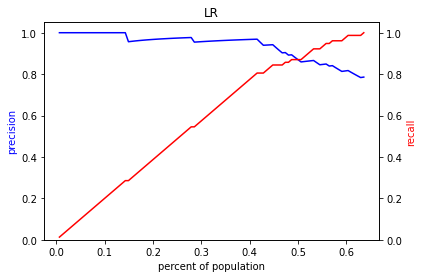

In [88]:
 plot_precision_recall_n(labels_binary[test_set_idx], y_score[:,1], 'LR')

If we examine our precision-recall curve we can see that our precision is 1 and recall is 0.8 up to 0.4 percent of the population. Unlike the previous example where we are using a precision at k curve to prioritize our resources. We can still use a precision at k curve to see what parts of the corpus can be tagged by the classifier and which should undergo a manual clerical review. Based on this we can make decisions of what documents should be manually tagged by a person during a clerical rewiew, say, the percent of the population above 40%. 

Alternatively, we can try to maximize the entire precision-recall space. In this case we need a different metric. 

In [89]:
def plot_precision_recall(y_true,y_score):
    """
    Plot a precision recall curve
    
    Parameters
    ----------
    y_true: ls
        ground truth labels
    y_score: ls
        score output from model
    """
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true,y_score[:,1])
    plt.plot(recall_curve, precision_curve)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    auc_val = auc(recall_curve,precision_curve)
    print('AUC-PR: {0:1f}'.format(auc_val))
    plt.show()
    plt.clf()

AUC-PR: 0.956387


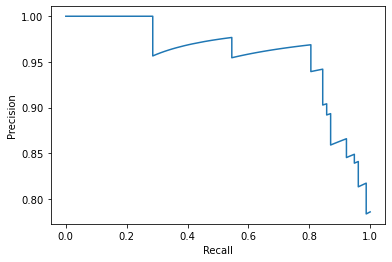

<Figure size 432x288 with 0 Axes>

In [90]:
plot_precision_recall(labels_binary[test_set_idx],y_score)

If we look at the area under the curve, 0.96, we see we have a very good classifier. The AUC shows how accurate our scores are under different cut-off thresholds. If you recall from the Machine Learning tutorial, the model outputs a score. We then set a cutoff to bin each score as a 0 or 1. The closer our scores are to the true values the more resilent they are to different cutoffs. For instance, if our scores were perfect our AUC would be 1. 

## Feature Importances

In [91]:
def display_feature_importances(coef,features, labels, num_features=10):
    """
    output feature importances
    
    Parameters
    ----------
    coef: numpy
        feature importances
    features: ls 
        feature names
    labels: ls
        labels for the classifier
    num_features: int
        number of features to output (default 10)
    
    Example
    --------
    
    
    """
    coef = mdl.coef_.ravel()

    dict_feature_importances = dict( zip(features, coef) )
    orddict_feature_importances = OrderedDict( 
                                    sorted(dict_feature_importances.items(), key=lambda x: x[1]) )

    ls_sorted_features  = list(orddict_feature_importances.keys())

    num_features = 10
    label0_features = ls_sorted_features[:num_features] 
    label1_features = ls_sorted_features[-num_features:] 

    print(labels[0],label0_features)
    print(labels[1], label1_features)

In [92]:
display_feature_importances(mdl.coef_.ravel(), features, ['Credit Analysts','Financial Examiner'])

Credit Analysts ['credit', 'portfolio', 'credit analyst', 'customers', 'credit analysis', 'credit risk', 'credito', 'de credito', 'collateral', 'de']
Financial Examiner ['local', 'advisor', 'regulations', 'fraud', 'br', 'national', 'compliance analyst', 'peoples', 'national bank', 'compliance']


The feature importances are which words are the most relevant for predicting the type of Job Ad. We would expect words like credit, customer and candidate to be found in ads for a Credit Analyst. While words like review officer, compliance would be found in ads for a Financial Examiner. 

## Cross-validation

Recall from the machine learning tutorial that we are seeking the find the most general pattern in the data in order to have to most general model that will be successfull at classfying new unseen data. Our previous strategy above was the *Out-of-sample and holdout set*. With this strategy we try to find a general pattern by randomly dividing our data into a test and training set based on some percentage split (e.g., 50-50 or 80-20). We train on the test set and evalute on the test set, where we pretend the test set is unforseen data. A significant drawback with this approach is we may be lucky or unlucky with our random split. A possible solution is to create many random splits into training and testing sets and evaluate each split to estimate the performance of a given model. 

A more sophisticated holdout training and testing procedure is *cross-validation*. In cross-validation we split our data into k-folds or k-partions, usually 5 or 10 folds. We then iterate k times. In each iteration one of the folds is used as a testing set and the rest of the folds are combined to form the training set. We can then evaluate the performance at each iteration to estimate the performance of a given method. An advantage of using cross-validation is all examples of data are used in the training set at least once. 


In [93]:
def create_test_train_bag_of_words(train_corpus, test_corpus):
    """
    Create test and training set bag of words
    
    
    Parameters
    ----------
    train_corpus: ls
        ls of raw text for text corpus.
    test_corpus: ls
        ls of raw text for train corpus. 
        
    Returns
    -------
    (train_bag_of_words,test_bag_of_words): scipy sparse matrix
        bag-of-words representation of train and test corpus
    features: ls
        ls of words used as features. 
    """
    #parameters for vectorizer 
    ANALYZER = "word" #unit of features are single words rather then phrases of words 
    STRIP_ACCENTS = 'unicode'
    TOKENIZER = None
    NGRAM_RANGE = (0,2) #Range for pharases of words
    MIN_DF = 0.01 # Exclude words that have a frequency less than the threshold
    MAX_DF = 0.8  # Exclude words that have a frequency greater then the threshold 

    vectorizer = CountVectorizer(analyzer=ANALYZER,
                                tokenizer=None, # alternatively tokenize_and_stem but it will be slower 
                                ngram_range=NGRAM_RANGE,
                                stop_words = stopwords.words('english'),
                                strip_accents=STRIP_ACCENTS,
                                min_df = MIN_DF,
                                max_df = MAX_DF)
    
    NORM = None #turn on normalization flag
    SMOOTH_IDF = True #prvents division by zero errors
    SUBLINEAR_IDF = True #replace TF with 1 + log(TF)
    USE_IDF = True #flag to control whether to use TFIDF

    transformer = TfidfTransformer(norm = NORM,smooth_idf = SMOOTH_IDF,sublinear_tf = True)

    #get the bag-of-words from the vectorizer and
    #then use TFIDF to limit the tokens found throughout the text 
    train_bag_of_words = vectorizer.fit_transform( train_corpus ) 
    test_bag_of_words = vectorizer.transform( test_corpus )
    if USE_IDF:
        train_tfidf = transformer.fit_transform(train_bag_of_words)
        test_tfidf = transformer.transform(test_bag_of_words)
    features = vectorizer.get_feature_names()

    
    return train_tfidf, test_tfidf, features

In [108]:
test_corpus

'deputy head of credit senior credit officer financial institutions country risk job title deputy head of credit senior credit officer financial institutions country risk job type permanent location london united kingdom job description purpose europe credit division eucr is an independent credit control function its principle responsibility is to maintain and monitor the quality of that part of the lending book falling within its jurisdiction europe africa and the middle east in accordance with bank policy and the procedures contained in standard instructions specifically team   is responsible for financial institutions including banks and insurance companies and country risk eucr will middot approve facilities for these customers as front office general managers have no authority for this group of clients middot recommend country ratings and country limits for all emea countries middot review and monitor the loan portfolio to maintain a balanced and quality driven asset base middot d

In [121]:
np.array(train_corpus.tolist() + test_corpus.tolist()).shape

(256,)

In [124]:
len(train_labels)

102

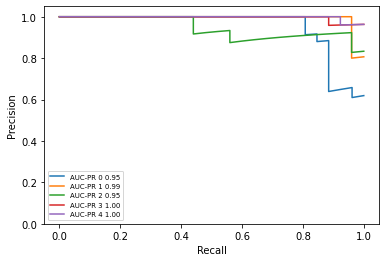

In [125]:
#from sklearn.cross_validation import StratifiedKFold
#cv = StratifiedKFold(train_labels_binary, n_folds=5)
# StratifiedKFold moved from sklearn.cross validation to sklearn.model_selection
# Update method and use required inputs 


from sklearn.model_selection import StratifiedKFold

combined_corpus = np.array(train_corpus.tolist() + test_corpus.tolist())
cv = StratifiedKFold(n_splits=5)
cv = cv.split(combined_corpus, labels)

labels_binary = le.transform(labels)
for i, (train,test) in enumerate(cv):
    cv_train = combined_corpus[train]
    cv_test = combined_corpus[test]
    bag_of_words_train, bag_of_words_test, feature_names = create_test_train_bag_of_words(cv_train, 
                                                                                          cv_test)
    
    probas_ = clf.fit(bag_of_words_train, 
                      labels_binary[train]).predict_proba(bag_of_words_test)
    cv_test_labels = labels_binary[test]
    
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(cv_test_labels,
                                                                          probas_[:,1])
    auc_val = auc(recall_curve,precision_curve)
    plt.plot(recall_curve, precision_curve, label='AUC-PR {0} {1:.2f}'.format(i,auc_val))
    
plt.ylim(0,1.05)    
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left", fontsize='x-small')

In this case we did 5-fold cross-validation and plotted precision-recall curves for each iteration. We can then average the AUC-PR of each iteration to estimate the performance of our method. 

## Examples of tagging

In [126]:
num_comments = 2
label0_comment_idx = y_score[:,1].argsort()[:num_comments] #SuicideWatch
label1_comment_idx = y_score[:,1].argsort()[-num_comments:] #depression
test_set_labels = labels[test_set_idx]
#convert back to the indices of the original dataset
top_comments_testing_set_idx = np.concatenate([label0_comment_idx, 
                                               label1_comment_idx])


#these are the 5 comments the model is most sure of 
for i in top_comments_testing_set_idx:
    print(
        u"""{}:{}\n---\n{}\n===""".format(test_set_labels[i],
                                          y_score[i,1],
                                          test_corpus[i]))

Credit Analysts:2.7992618432224073e-05
---
title sr credit analyst i location new york rochester m  t place other locations together m t bank and wilmington trust a part of m t bank corporation represent one of the countrys leading depository and lending franchises a premier wealth advisory firm and the partner of choice for corporate transactions and structures as one of strongest most successful companies in the u s financial services industry m t continues to grow offering value to our shareholders and opportunity to qualified professionals join our team of over     professionals and youll understand what drives our longstanding success a promise of exceptional client service a commitment to our communities a focus on building long term relationships and a dedication to being the best employer youll ever have basic function evaluate and determine the credit risks of the higher dollar amount and more complex commercial clients through detailed financial statement analysis industry as

These are the top-2 example for each label that the model is sure of. In this case we can see our important feature words in the ads and see how the model classified these advertisements. 

# Further Resources

A great resource for NLP in python is 
[Natural Language Processing with Python](https://www.amazon.com/Natural-Language-Processing-Python-Analyzing/dp/0596516495)

# Exercises 

Work thorugh the Reddit_TextAnalysis.ipynb notebook.